# Generative Adversarial Neural Network for the MNIST Dataset

See the original GAN [paper](https://arxiv.org/pdf/1406.2661.pdf) and this Open AI [blog post](https://openai.com/blog/generative-models/) related to this [article](https://arxiv.org/abs/1606.03498).

In implementing this, I have used some of the recommendations given in the [DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf).

Finally, TensorFlow has recently added a [blog post](https://www.tensorflow.org/tutorials/generative/dcgan) on a simple DCGAN for the MNIST dataset. While that tutorial is quite concise, there are some aspects that presumably require further clarification. I have deliberately set the size of hidden representation to a small number (~32). The main reason for this is that the MNIST data already is fairly restricted and the dataset has a much smaller information content than, say, CIFAR-10.  

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np

from tqdm.notebook import tqdm

from IPython.display import clear_output

import utilities as utils
import models 

<br><br><br>

# Training Parameters 

In [2]:
batch_size = 16 #256
num_epochs = 100
generator_input_size = 16

<br><br><br>

# Input Data Pipeline

## Load MNIST Dataset

In [3]:
train_set, test_set = tf.keras.datasets.mnist.load_data()
print(f"\tTrain set: {train_set[0].shape}, {train_set[1].shape}")
print(f"\tTest set:  {test_set[0].shape}, {test_set[1].shape}")

	Train set: (60000, 28, 28), (60000,)
	Test set:  (10000, 28, 28), (10000,)


## Setup Data Pipeline:

In [4]:
dataset = tf.data.Dataset.from_tensor_slices(train_set[0])
dataset = dataset.batch(batch_size, drop_remainder=True)

def include_gen_model_input(
    x, batch_size=batch_size, 
    generator_input_size=generator_input_size,
    uniform_dist=True):
    if uniform_dist:
        x_gen = tf.random.uniform(
            shape=(batch_size, generator_input_size), 
            minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
    else:    
        x_gen = tf.random.normal(
            shape=(batch_size, generator_input_size), 
            mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
    x = tf.cast(x, dtype=tf.float32)
    x = tf.expand_dims(x, axis=-1)
    return (x, x_gen)
dataset = dataset.map(include_gen_model_input)

# Draw samples from the data pipeline
for element in dataset.take(3):
    print("\t", element[0].shape, ", ", element[0].dtype.name, 
          "\t", element[1].shape, ", ", element[1].dtype.name)
print("\t\t.\n"*3)

	 (16, 28, 28, 1) ,  float32 	 (16, 16) ,  float32
	 (16, 28, 28, 1) ,  float32 	 (16, 16) ,  float32
	 (16, 28, 28, 1) ,  float32 	 (16, 16) ,  float32
		.
		.
		.



<br><br><br>

# Train the Generator Model in an Adversarial Setting

## Instantiate Discriminator and Generator Models

In [5]:
# Instantiate
discriminator_model = models.construct_discriminator_model(
    activation="leakyrelu", output_softmax=False)
generator_model = models.construct_generator_model(
        input_size=generator_input_size, 
        output_activation="linear",
        with_batchnorm=True)

# Print Summaries
discriminator_model.summary(print_fn=(lambda *args: print("\t", *args)))
print("\n\n")
generator_model.summary(print_fn=(lambda *args: print("\t", *args)))

	 Model: "discriminator"
	 _________________________________________________________________
	 Layer (type)                 Output Shape              Param #   
	 input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
	 _________________________________________________________________
	 conv_1 (Conv2D)              (None, 28, 28, 8)         208       
	 _________________________________________________________________
	 leaky_relu_1 (LeakyReLU)     (None, 28, 28, 8)         0         
	 _________________________________________________________________
	 conv_2 (Conv2D)              (None, 28, 28, 32)        6432      
	 _________________________________________________________________
	 leaky_relu_2 (LeakyReLU)     (None, 28, 28, 32)        0         
	 _________________________________________________________________
	 flatten (Flatten)            (None, 25088)             0         
	 _________________________________________________________________
	 output (Dense)       

## Create and Initialize the Custom GAN Training Class

In [6]:
# optimizer = tf.keras.optimizers.SGD(
#     learning_rate=0.0001, 
#     momentum=0.0, nesterov=False, name="SGD")
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0001, name="adam")

train_gan = models.Train_GAN_Modules(
    discriminator_model=discriminator_model,
    generator_model=generator_model,
    batch_size=batch_size,
    optimizer=optimizer,
    from_logits=True)

## Write GAN Training Graph to TensorBoard File

In [7]:
write_to_tensorboard = False

if write_to_tensorboard:
    writer = tf.summary.create_file_writer("./logdir")

    tf.summary.trace_on(graph=True, profiler=False)

    output = train_gan._train_step(
        tf.zeros((batch_size, 28, 28, 1), dtype=tf.float32), 
        tf.zeros((batch_size, generator_input_size), dtype=tf.float32), 
        train_gan._batch_of_ones, train_gan._batch_of_zeros)

    with writer.as_default():
        tf.summary.trace_export(
            name="_train_step_trace",
            step=0,
            profiler_outdir="./logdir")

## Sample of Generated Images before Training:

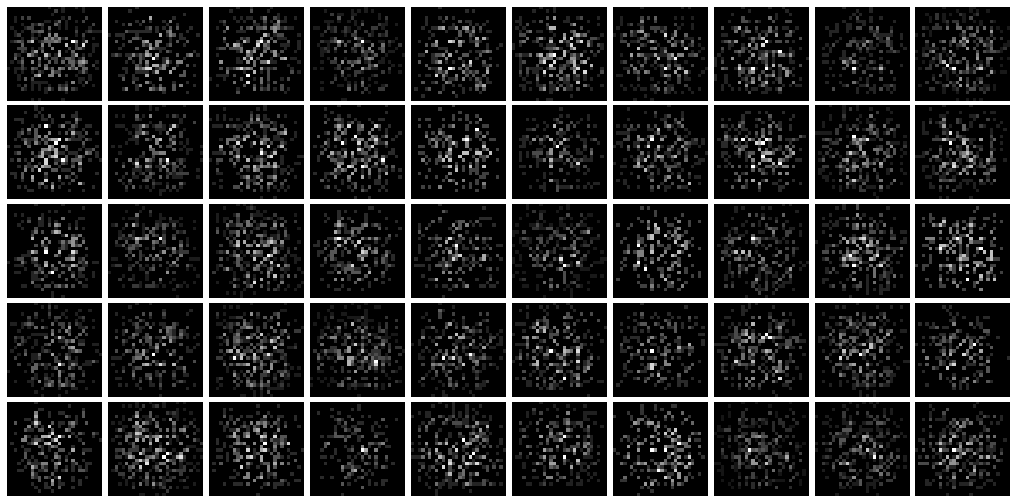

In [8]:
num_rows = 5
num_cols = 10

# Generate some images:
x = tf.random.normal(
    shape=(num_rows * num_cols, generator_input_size), 
    mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
images = train_gan.generator_model(x).numpy()

fig = plt.figure(figsize=(18., 9.))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.05, hspace=0.05)
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        image = images[idx]
        image = np.clip(image, 0.0, 255.0).astype(np.uint8)
        #
        ax.imshow(image, cmap="gray")
        ax.axis("off")
plt.show()

## Train the GAN Model

In [ ]:
learning_rate_decay = None  # Set to `None` to disable learning rate decay

pbar_format = "{percentage:3.0f}%|{bar}|{n_fmt}/{total_fmt} [{elapsed} < {remaining}, {rate_fmt}{postfix}] {desc}"
train_history = []
for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}", flush=True)
    if learning_rate_decay is not None:
        print(f"\nLearning Rate: {tf.keras.backend.eval(train_gan.optimizer.learning_rate):2.2e}")
    train_gan.reset_accumulated_losses()
    pbar = tqdm(dataset.take(-1).enumerate(start=1), bar_format=pbar_format)
    for idx, element in pbar: 
        image_batch, generator_input_batch = element
        losses = train_gan.train_step(
            image_batch,
            generator_input_batch)
        pbar.set_description_str(f"Losses: (Disc: {round(losses[0], 3)}, Gen: {round(losses[1], 3)})")
        train_history.append([l for l in losses])
    #
    ## Clear output:
    clear_output(wait=True)
    #
    ## Print avg. previous epoch loss
    print(f"\nEpoch {epoch}/{num_epochs} Avg. Losses:", flush=True)
    accumulated_losses = train_gan.get_accumulated_losses()
    for loss_name, loss_val in accumulated_losses.items():
        print(f"\t{loss_name:24} {round(loss_val, 5)}", flush=True)
    #
    ## Set new learning rate:
    if learning_rate_decay is not None:
        lr = tf.keras.backend.eval(train_gan.optimizer.learning_rate)
        tf.keras.backend.set_value(train_gan.optimizer.learning_rate, lr * learning_rate_decay)


Epoch 11/100 Avg. Losses:
	Discriminator Loss       0.17039
	Generator Loss           51.76405

Epoch 12/100


  0%|          |0/3750 [00:00 < ?, ?it/s] 

In [ ]:
# Plot training history:
losses_array = np.array(train_history, dtype=np.float32)

fig = plt.figure(figsize=(18., 6.))
#
plt.title("Full Training History", fontsize=16., color="darkgray")
plt.xlabel("Batch Number", fontsize=14., color="darkgray")
plt.ylabel("CE Loss", fontsize=14., color="darkgray")
plt.plot(losses_array[:, 0], lw=2, c="steelblue", alpha=0.75, label="Discriminator")
plt.plot(losses_array[:, 1], lw=2, c="salmon", alpha=0.75, label="Generator")
plt.grid()
plt.gca().set_axisbelow(True)
plt.legend(fontsize=14)
plt.yscale("log")
#
plt.show()

<br><br><br>

# Generate Images

In [ ]:
num_rows = 5
num_cols = 10

# Generate some images:
x = tf.random.normal(
    shape=(num_rows * num_cols, generator_input_size), 
    mean=0.0, stddev=1.0, dtype=tf.dtypes.float32)
images = train_gan.generator_model(x).numpy()

fig = plt.figure(figsize=(18., 9.))
gs = gridspec.GridSpec(num_rows, num_cols)
gs.update(wspace=0.05, hspace=0.05)
for row in range(num_rows):
    for col in range(num_cols):
        idx = row * num_cols + col
        ax = plt.subplot(gs[idx])
        image = images[idx]
        image = np.clip(image, 0.0, 255.0).astype(np.uint8)
        #
        ax.imshow(image, cmap="gray")
        ax.axis("off")
plt.show()

<br><br><br>

# Save Models

In [ ]:
train_gan.discriminator_model.save(
    filepath="discriminator_model.h5", 
    overwrite=True, include_optimizer=False, save_format="h5")

In [ ]:
train_gan.generator_model.save(
    filepath="generator_model.h5", 
    overwrite=True, include_optimizer=False, save_format="h5")